In [1]:
import os
file_path = os.path.abspath("school_safety_all_data_gini.csv")
print(file_path)

C:\Users\ryanb\Semester 8\DS 490 Capstone\DS 490 Report Writing\school_safety_all_data_gini.csv


In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_csv(r'C:\Users\ryanb\Semester 8\DS 490 Capstone\DS 490 Report Writing\school_safety_all_data_gini.csv')

In [5]:
df = df.drop('Unnamed: 0', axis=1)

In [6]:
zero_count = (df['Shooter_Killed'] == 1).sum()
print(f"Number of 1 in the 'Shooter_Killed' column: {zero_count}")

Number of 1 in the 'Shooter_Killed' column: 235


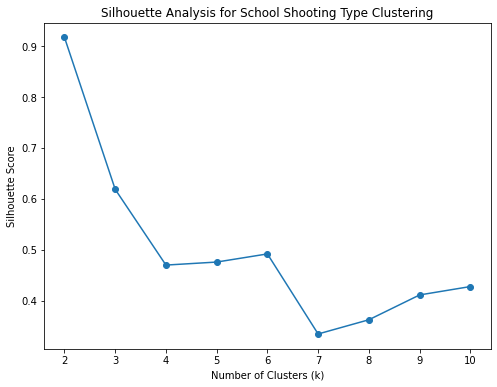

Optimal number of clusters (based on silhouette analysis): 2
Cluster 0 Characteristics:
       Cluster  Shooter_Killed  Victims_Killed  Victims_Wounded  \
count   2564.0     2564.000000     2564.000000      2564.000000   
mean       0.0        0.091654        0.267161         0.758190   
std        0.0        0.291284        0.555887         1.284998   
min        0.0        0.000000        0.000000         0.000000   
25%        0.0        0.000000        0.000000         0.000000   
50%        0.0        0.000000        0.000000         0.000000   
75%        0.0        0.000000        0.000000         1.000000   
max        0.0        2.000000        8.000000        18.000000   

       Number_Victims  \
count     2564.000000   
mean         1.025351   
std          1.442533   
min          0.000000   
25%          0.000000   
50%          1.000000   
75%          1.000000   
max         20.000000   

       Income_Overview_Characteristic_Per_Capita_Income_Measure  
count           

In [7]:
features = ['Shooter_Killed',
            'Victims_Killed',
            'Victims_Wounded',
            'Number_Victims',
            'Income_Overview_Characteristic_Per_Capita_Income_Measure']

X = df[features]

X = X.fillna(X.mean())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k_range = range(2, 11)

inertia_scores = []
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia_scores.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

plt.figure(figsize=(8, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for School Shooting Type Clustering')
plt.show()

optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal number of clusters (based on silhouette analysis): {optimal_k}")

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

cluster_data = pd.DataFrame({'Cluster': cluster_labels})
cluster_data = pd.concat([cluster_data, X], axis=1)
for cluster in range(optimal_k):
    print(f"Cluster {cluster} Characteristics:")
    print(cluster_data[cluster_data['Cluster'] == cluster].describe())
    print()

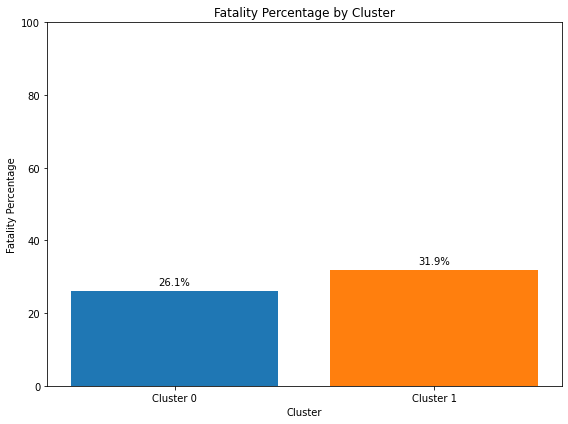

Type 1 Clusters (Fatality Percentage < 10%):

Type 2 Clusters (Fatality Percentage > 25%):
Cluster 0: 26.06%
Cluster 1: 31.86%


In [8]:
fatality_percentages = []
for cluster in range(optimal_k):
    cluster_data = X[cluster_labels == cluster]
    total_incidents = len(cluster_data)
    total_victims = cluster_data['Number_Victims'].sum()
    total_fatalities = cluster_data['Victims_Killed'].sum()
    fatality_percentage = (total_fatalities / total_victims) * 100 if total_victims > 0 else 0
    fatality_percentages.append(fatality_percentage)

colors = ['#1f77b4', '#ff7f0e']

plt.figure(figsize=(8, 6))
bars = plt.bar(range(optimal_k), fatality_percentages, color=colors)
plt.xlabel('Cluster')
plt.ylabel('Fatality Percentage')
plt.title('Fatality Percentage by Cluster')
plt.xticks(range(optimal_k), [f'Cluster {i}' for i in range(optimal_k)])
plt.ylim(0, 100)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

type1_clusters = [i for i in range(optimal_k) if fatality_percentages[i] < 10]
type2_clusters = [i for i in range(optimal_k) if fatality_percentages[i] > 25]

print("Type 1 Clusters (Fatality Percentage < 10%):")
for cluster in type1_clusters:
    print(f"Cluster {cluster}: {fatality_percentages[cluster]:.2f}%")

print("\nType 2 Clusters (Fatality Percentage > 25%):")
for cluster in type2_clusters:
    print(f"Cluster {cluster}: {fatality_percentages[cluster]:.2f}%")

Average income for cluster 0: $35764.91
Average income for cluster 1: $42206.62


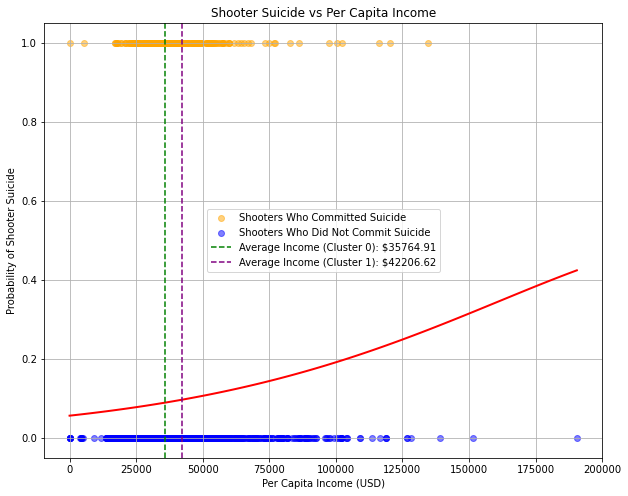

In [10]:
features = ['Shooter_Killed', 'Income_Overview_Characteristic_Per_Capita_Income_Measure']

X = df[features]

X = X.fillna(X.mean())

X['Cluster'] = cluster_labels

cluster_0_income = X[X['Cluster'] == 0]['Income_Overview_Characteristic_Per_Capita_Income_Measure'].mean()
cluster_1_income = X[X['Cluster'] == 1]['Income_Overview_Characteristic_Per_Capita_Income_Measure'].mean()

print(f"Average income for cluster 0: ${cluster_0_income:.2f}")
print(f"Average income for cluster 1: ${cluster_1_income:.2f}")

X_income = X['Income_Overview_Characteristic_Per_Capita_Income_Measure'].values.reshape(-1, 1)
y_suicide = X['Shooter_Killed'].values

scaler = StandardScaler()
X_income_scaled = scaler.fit_transform(X_income)

logistic_regression = LogisticRegression()
logistic_regression.fit(X_income_scaled, y_suicide)

income_range = np.linspace(X_income.min(), X_income.max(), 100).reshape(-1, 1)
income_range_scaled = scaler.transform(income_range)
suicide_probabilities = logistic_regression.predict_proba(income_range_scaled)[:, 1]

plt.figure(figsize=(10, 8))
plt.plot(income_range, suicide_probabilities, color='red', linewidth=2)
plt.scatter(X_income[y_suicide == 1], y_suicide[y_suicide == 1], color='orange', alpha=0.5, label='Shooters Who Committed Suicide')
plt.scatter(X_income[y_suicide == 0], y_suicide[y_suicide == 0], color='blue', alpha=0.5, label='Shooters Who Did Not Commit Suicide')
plt.axvline(x=cluster_0_income, color='green', linestyle='--', label=f'Average Income (Cluster 0): ${cluster_0_income:.2f}')
plt.axvline(x=cluster_1_income, color='purple', linestyle='--', label=f'Average Income (Cluster 1): ${cluster_1_income:.2f}')
plt.xlabel('Per Capita Income (USD)')
plt.ylabel('Probability of Shooter Suicide')
plt.title('Shooter Suicide vs Per Capita Income')
plt.grid(True)
plt.legend()
plt.show()

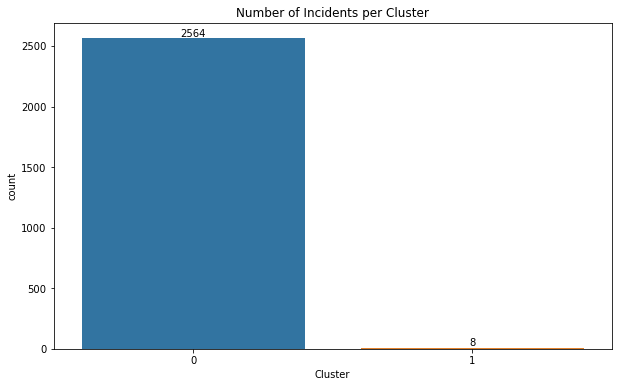

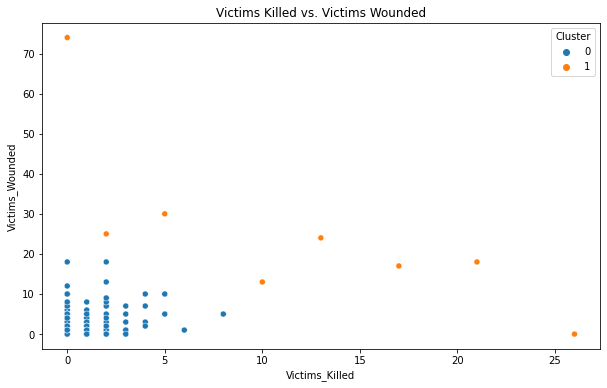

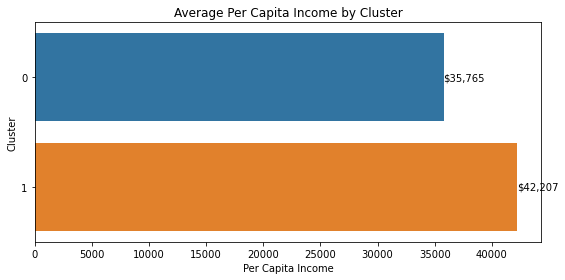

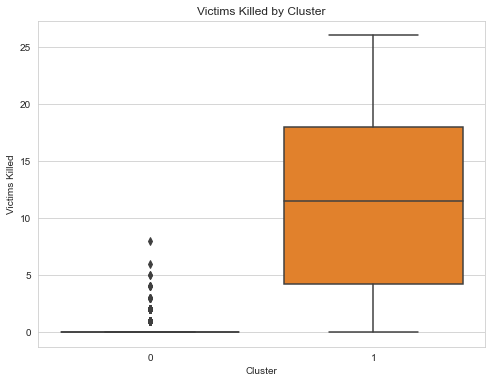

In [11]:
cluster_data = pd.DataFrame({'Cluster': cluster_labels})
cluster_data = pd.concat([cluster_data, df], axis=1)

custom_palette = ["#1f77b4", "#ff7f0e"]

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Cluster', data=cluster_data, palette=custom_palette)
plt.title('Number of Incidents per Cluster')

for p in ax.patches:
    count = p.get_height()
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 0.1
    ax.text(x, y, int(count), ha='center', va='bottom')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Victims_Killed', y='Victims_Wounded', hue='Cluster', data=cluster_data, palette=custom_palette)
plt.title('Victims Killed vs. Victims Wounded')
plt.show()

cluster_numbers = cluster_data['Cluster'].unique()

plt.figure(figsize=(8, 4))
ax = sns.barplot(x='Income_Overview_Characteristic_Per_Capita_Income_Measure', y='Cluster', data=cluster_data, palette=custom_palette, orient='h', ci=None)
plt.title('Average Per Capita Income by Cluster')
plt.xlabel('Per Capita Income')
plt.ylabel('Cluster')

for i, v in enumerate(cluster_data.groupby('Cluster')['Income_Overview_Characteristic_Per_Capita_Income_Measure'].mean()):
    ax.text(v + 0.1, i, f'${v:,.0f}', va='center')

plt.tight_layout()
plt.show()

sns.set_style("whitegrid")

cluster_colors = custom_palette

fig, ax = plt.subplots(figsize=(8, 6))

sns.boxplot(x='Cluster', y='Victims_Killed', data=cluster_data, ax=ax, palette=cluster_colors)
ax.set_title("Victims Killed by Cluster")
ax.set_xlabel("Cluster")
ax.set_ylabel("Victims Killed");

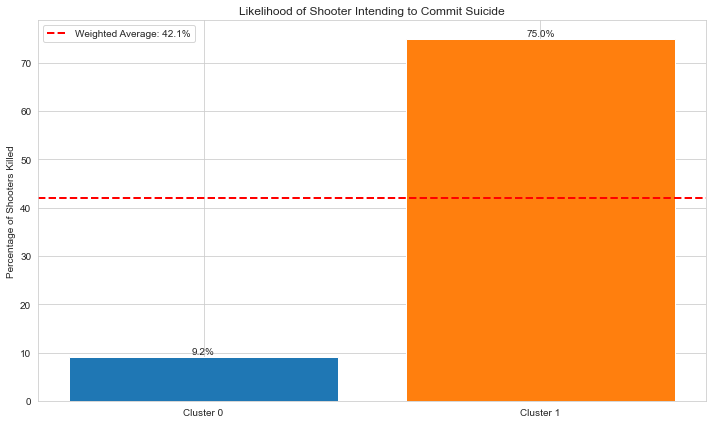

In [20]:
clusters = ['Cluster 0', 'Cluster 1']
incidents = [2564, 8]
shooters_killed = [235, 6]

percentages = [sk / inc * 100 for sk, inc in zip(shooters_killed, incidents)]

colors = ['#1f77b4', '#ff7f0e']

weights = [0.5, 0.5]

weighted_average = sum(p * w for p, w in zip(percentages, weights))

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(clusters, percentages, color=colors)

ax.set_ylabel('Percentage of Shooters Killed')
ax.set_title('Likelihood of Shooter Intending to Commit Suicide')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}%', ha='center', va='bottom')

ax.axhline(weighted_average, color='red', linestyle='--', linewidth=2, label=f'Weighted Average: {weighted_average:.1f}%')
ax.legend()

plt.tight_layout()
plt.show()